In [62]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import tensorflow as tf
import numpy as np

In [5]:
# load the training set
df_train = pd.read_csv("/Users/Golnoush/Desktop/Stock_price_direction/data/raw/AMZN_train.csv")

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4781 entries, 0 to 4780
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4781 non-null   object 
 1   Open       4781 non-null   float64
 2   High       4781 non-null   float64
 3   Low        4781 non-null   float64
 4   Close      4781 non-null   float64
 5   Adj Close  4781 non-null   float64
 6   Volume     4781 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 261.6+ KB


In [7]:
df_train.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4781.000000,4781.000000,4781.000000,4781.000000,4781.000000,4.781000e+03
mean,127.619845,129.480122,125.697925,127.662449,127.662449,8.225935e+06
std,145.693083,147.132537,144.053633,145.677581,145.677581,7.810188e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,34.299999,34.849998,33.660000,34.310001,34.310001,4.200900e+06
50%,62.880001,64.750000,60.937500,62.750000,62.750000,6.200100e+06
75%,189.009995,191.600006,186.210007,189.029999,189.029999,9.239900e+06
max,717.380005,722.450012,711.510010,717.929993,717.929993,1.043292e+08


In [8]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [9]:
df_train["Date"].describe()

count           4781
unique          4781
top       1997-05-15
freq               1
Name: Date, dtype: object

In [10]:
# print the time range
df_train["Date"].min(), df_train["Date"].max()

('1997-05-15', '2016-05-13')

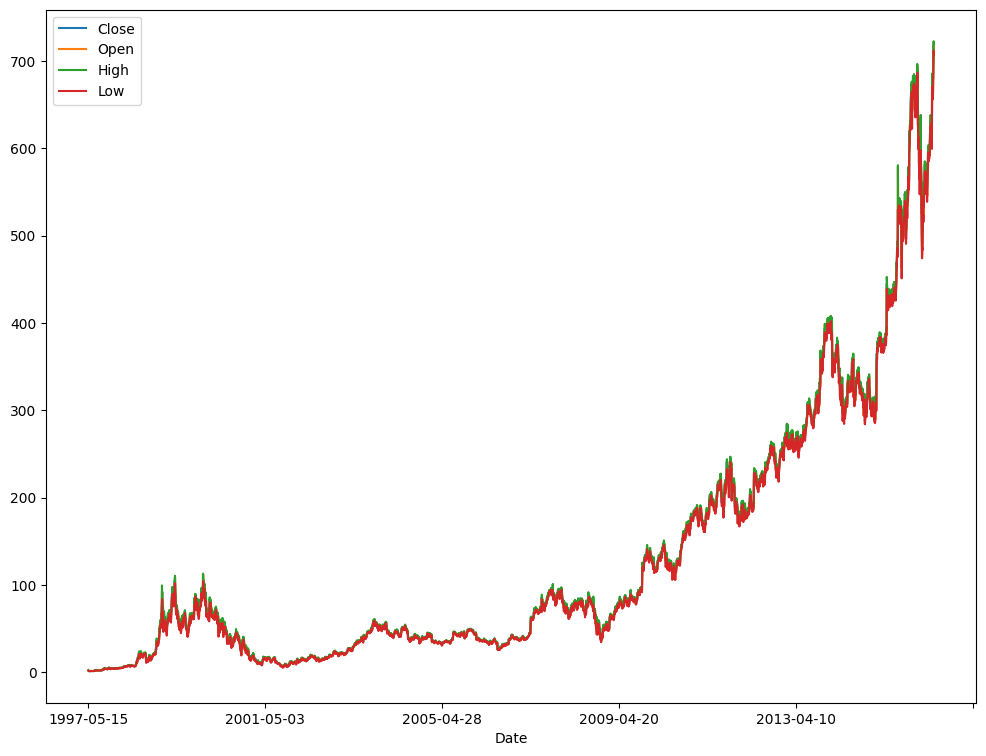

In [13]:
plt.rcParams["figure.figsize"] = (12, 9)
_ = df_train.plot(x="Date", y=["Close", "Open", "High", "Low"])

In [14]:
def analyse(dataframe):
    """Runs an exploration analysis of the dataframe."""
    print("Shape", dataframe.shape, "\n")
    print("Columns", dataframe.columns, "\n")
    dataframe.info()
    print("\n", dataframe.describe(), "\n")
    print("The data ranges from", dataframe["Date"].min(), "to", dataframe["Date"].max())
    dataframe.plot(x="Date", y=["Close", "Open", "High", "Low"])

Shape (503, 7) 

Columns Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       503 non-null    object 
 1   Open       503 non-null    float64
 2   High       503 non-null    float64
 3   Low        503 non-null    float64
 4   Close      503 non-null    float64
 5   Adj Close  503 non-null    float64
 6   Volume     503 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 27.6+ KB

               Open         High          Low        Close    Adj Close  \
count   503.000000   503.000000   503.000000   503.000000   503.000000   
mean    992.201292   999.898131   982.574513   991.828966   991.828966   
std     255.496588   259.220381   250.100614   254.885469   254.885469   
min     689.559998   696.820007   682.119995   691.359985   6

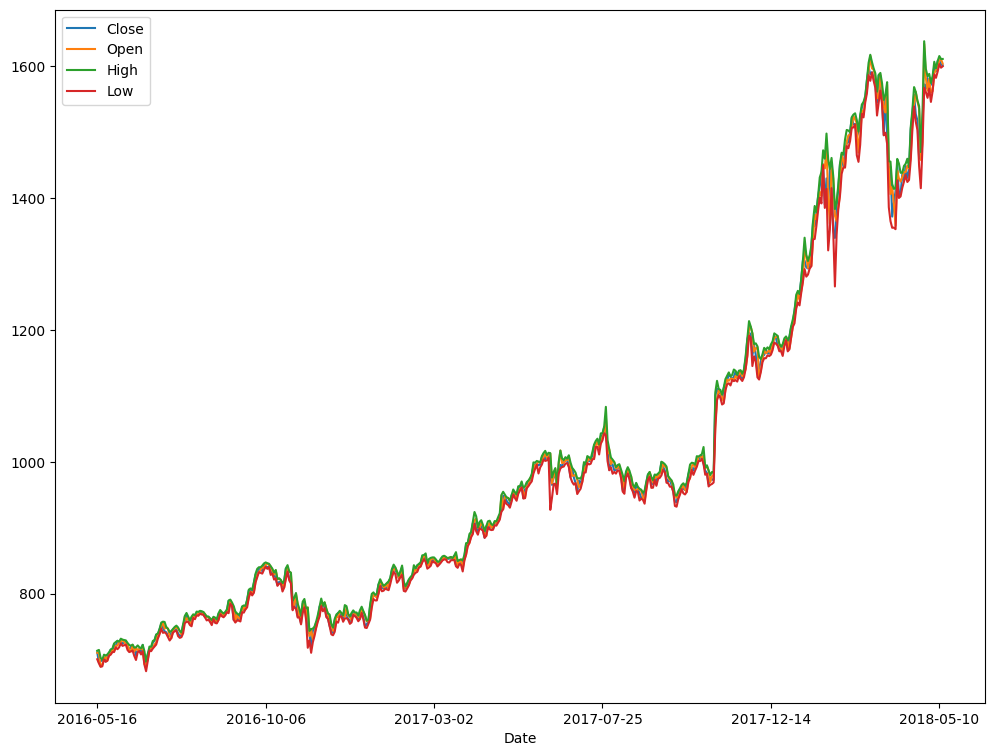

In [15]:
# read validation and test sets and then analyse them
df_val = pd.read_csv("/Users/Golnoush/Desktop/Stock_price_direction/data/raw/AMZN_val.csv")
analyse(df_val)

Shape (504, 7) 

Columns Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       504 non-null    object 
 1   Open       504 non-null    float64
 2   High       504 non-null    float64
 3   Low        504 non-null    float64
 4   Close      504 non-null    float64
 5   Adj Close  504 non-null    float64
 6   Volume     504 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 27.7+ KB

               Open         High          Low        Close    Adj Close  \
count   504.000000   504.000000   504.000000   504.000000   504.000000   
mean   1823.927758  1843.069246  1803.067065  1824.040536  1824.040536   
std     178.129809   179.294163   177.457741   178.470078   178.470078   
min    1346.000000  1396.030029  1307.000000  1343.959961  13

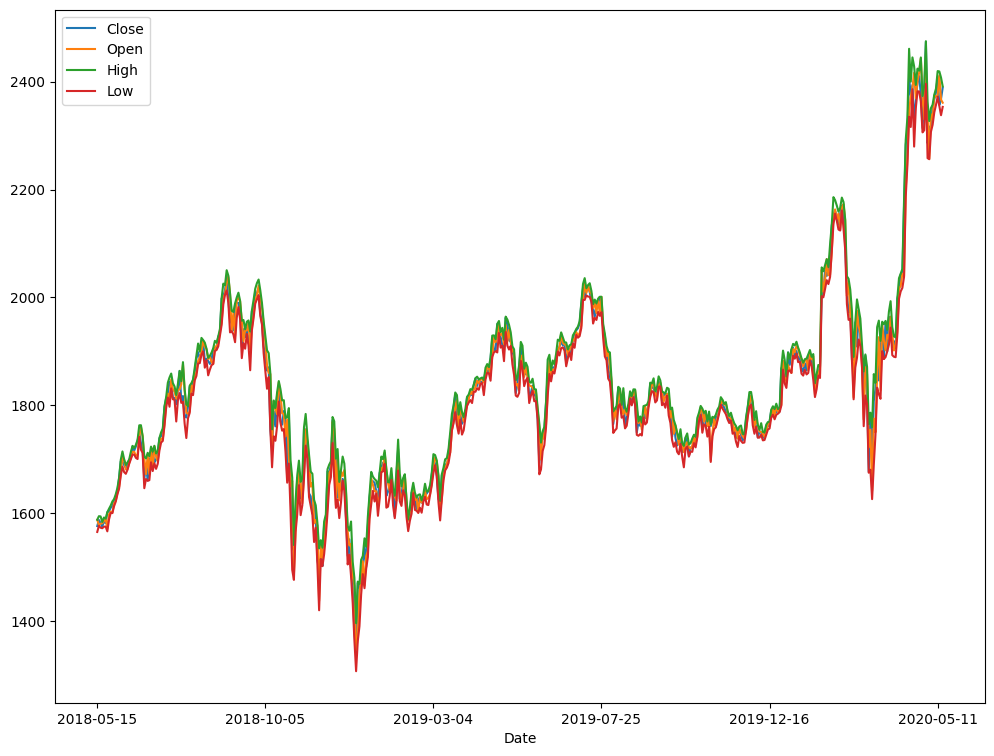

In [17]:
df_test = pd.read_csv("/Users/Golnoush/Desktop/Stock_price_direction/data/raw/AMZN_test.csv")
analyse(df_test)

Once we have done our exploration of the data, we can move on to the predictive modeling part of the task. The task was to predict if the next day's closing price will be higher than the opening price. We do not have that information explicitly in our data, so we have to infer it.

This is relatively simple, we just need to compare the closing and opening prices one day in advance.

To achieve that, first, we will make sure that the data is sorted by the date. We can use the sort_values method and pass in the Date column as a parameter, sorting it in ascending order.

Next, we need to shift the DataFrame by one row / one day and compare the prices. Pandas has a method for doing exactly that, the shift method. We specify a period of minus one (so that we shift the data from the next day back). Because it is a logical operation, Pandas would return a True / False result for each comparison. We want this to be presented as 1 / 0 for the machine learning models, so we will map it to type int. To store all of this information, we will create a new column, called Target.

In [18]:
# make sure that our data is sorted by date
df_train.sort_values(by="Date", inplace=True)
df_val.sort_values(by="Date", inplace=True)
df_test.sort_values(by="Date", inplace=True)

In [19]:
# notice that we shift by a period of '-1', this takes the next day's price direction for the current day
# a positive period will take the days from the past
df_train["Target"] = (df_train["Close"] > df_train["Open"]).shift(periods=-1, fill_value=0).astype(int)

In [20]:
df_train

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,0
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,0
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,0
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,0
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,0
...,...,...,...,...,...,...,...,...
4776,2016-05-09,673.950012,686.979980,671.409973,679.750000,679.750000,3982200,1
4777,2016-05-10,694.000000,704.549988,693.500000,703.070007,703.070007,6105600,1
4778,2016-05-11,705.789978,719.000000,701.650024,713.229980,713.229980,7338200,1
4779,2016-05-12,717.380005,722.450012,711.510010,717.929993,717.929993,5048200,0


Running the value_counts method on the Target column gives us the distribution. We have 2292 days where the closing price is higher than the opening and 2389 where it is lower.

In [21]:
df_train["Target"].value_counts()

Target
1    2392
0    2389
Name: count, dtype: int64

In [22]:
df_val["Target"] = (df_val["Close"] > df_val["Open"]).shift(periods=-1, fill_value=0).astype(int)
df_val["Target"].value_counts()

Target
0    255
1    248
Name: count, dtype: int64

In [23]:
df_test["Target"] = (df_test["Close"] > df_test["Open"]).shift(periods=-1, fill_value=0).astype(int)
df_test["Target"].value_counts()

Target
1    255
0    249
Name: count, dtype: int64

At this point, we can start building some machine learning models to predict the target variable. But, before we do that, it might be useful to engineer some additional features that may help us better predict the price direction. In the next section, we will explore some possibilities for doing feature engineering.

Feature Engineering

We know that the stock prices are time-dependent and that the next day's price depends on prices (and many other things) from previous days.

We want to somehow take into account all the values in the last n days, capturing the trend, or the magnitude of price change.

A simple solution would be to calculate a moving average. With Pandas, we can use the rolling method to calculate moving averages. It provides us with an interface for sliding (in Pandas terminology - rolling) window calculations. The following cells calculate the 3- and 7-days moving average, and add them as a feature into the data set.

Remember that we have our data sorted from before. If the data is not sorted by the date, the results from the rolling() method would be invalid.

In [24]:
df_train["Moving_Average_3"] = (df_train["Close"] - df_train["Open"]).rolling(window=3, min_periods=1).mean()
df_val["Moving_Average_3"] = (df_val["Close"] - df_val["Open"]).rolling(window=3, min_periods=1).mean()
df_test["Moving_Average_3"] = (df_test["Close"] - df_test["Open"]).rolling(window=3, min_periods=1).mean()

In [25]:
df_train["Moving_Average_7"] = (df_train["Close"] - df_train["Open"]).rolling(window=7, min_periods=1).mean()
df_val["Moving_Average_7"] = (df_val["Close"] - df_val["Open"]).rolling(window=7, min_periods=1).mean()
df_test["Moving_Average_7"] = (df_test["Close"] - df_test["Open"]).rolling(window=7, min_periods=1).mean()

Feature engineering can be simpler, we can just take the current day's price direction or the price range. Anything that comes to mind, that can be considered to be useful, should be tested and tried.

In [26]:
# current price direction
df_train["Today_Direction"] = df_train["Close"] - df_train["Open"]
df_val["Today_Direction"] = df_val["Close"] - df_val["Open"]
df_test["Today_Direction"] = df_test["Close"] - df_test["Open"]

In [ ]:
# price range
df_train["Price_Range"] = df_train["High"] - df_train["Low"]
df_val["Price_Range"] = df_val["High"] - df_val["Low"]
df_test["Price_Range"] = df_test["High"] - df_test["Low"]

The next cell displays a sample of the data with the new features included.

In [27]:
df_train.sample(10, random_state=42)

,Date,Open,High,Low,Close,Adj Close,Volume,Target,Moving_Average_3,Moving_Average_7,Today_Direction
2895,2008-11-14,43.610001,44.500000,41.500000,41.750000,41.750000,11949700,0,-0.253335,-0.601429,-1.860001
4430,2014-12-22,301.940002,307.359985,301.940002,306.540009,306.540009,4003800,0,0.436666,-0.705710,4.600007
3618,2011-09-29,234.169998,234.300003,216.289993,222.440002,222.440002,9378500,0,-6.126663,-2.434283,-11.729996
763,2000-05-24,46.437500,49.750000,40.437500,48.562500,48.562500,11666600,0,-0.937500,-0.580357,2.125000
4392,2014-10-28,289.760010,298.000000,289.760010,295.589996,295.589996,5572600,0,4.253326,2.681423,5.829986
4657,2015-11-16,640.919983,649.989990,622.289978,647.809998,647.809998,7435900,0,-7.243347,-0.264299,6.890015
4008,2013-04-22,259.350006,264.600006,258.029999,263.549988,263.549988,2119100,1,-0.343333,-0.287140,4.199982
555,1999-07-29,51.187500,52.187500,50.000000,50.781250,50.781250,18748000,0,-0.841146,-0.713170,-0.406250
2754,2008-04-28,80.639999,82.500000,80.120003,81.970001,81.970001,10991900,0,1.453336,1.212857,1.330002
33,1997-07-02,1.515625,1.593750,1.510417,1.588542,1.588542,3882000,1,0.026042,0.004464,0.072917


In [32]:
# this is the target column that we aim to predict
y_col = "Target"
# these are the input features for the models
X_cols = [
    "Open",
    "Close",
    "High",
    "Low",
    "Volume",
    "Adj Close",
    "Today_Direction",
    "Moving_Average_3",
    "Moving_Average_7"
]

In [33]:
X_train = df_train[X_cols]
y_train = df_train[y_col]

X_val = df_val[X_cols]
y_val = df_val[y_col]

X_test = df_val[X_cols]
y_test = df_val[y_col]

Logistic Regression

We start our modeling phase with a LogisticRegression model.

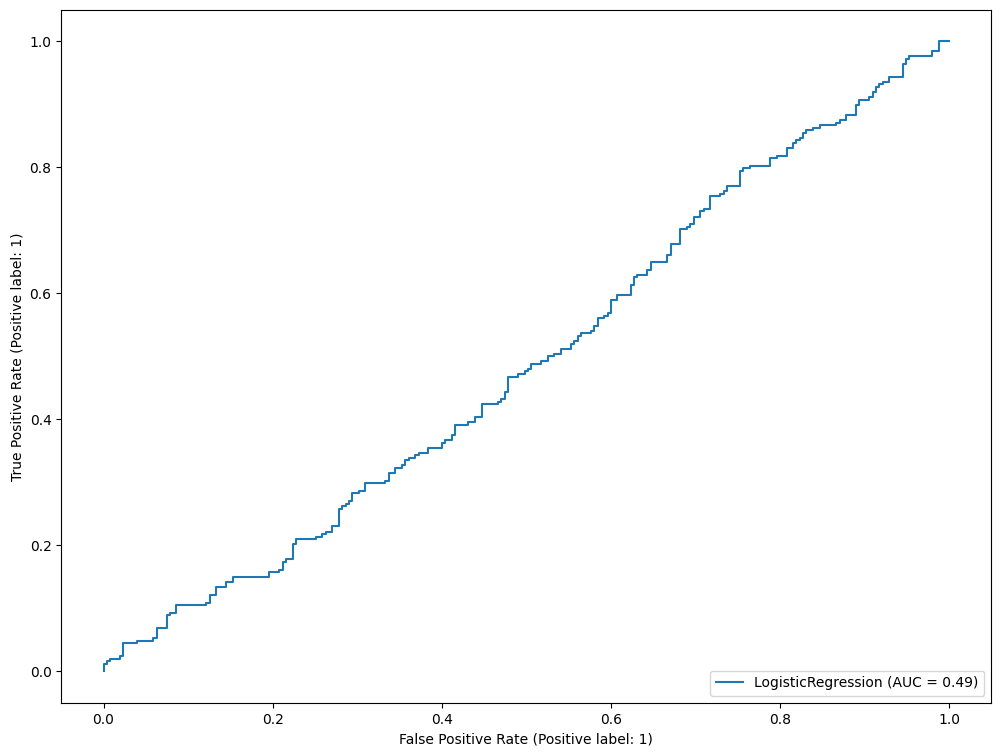

In [42]:
# for reproducibility
RANDOM_SEED = 42

# use default parameters
lr = LogisticRegression()

# fit to train set
lr.fit(X_train, y_train)

# plot ROC curve, and show AUC for the validation set
RocCurveDisplay.from_estimator(lr, X_val, y_val)

Logistic regression does not work well for this problem. Having AUC < 0.5 means that the classifier is worse than just randomly guessing the output. Given that we are dealing with a very difficult problem, any AUC > 0.5 would suffice for this task.

Decision Tree

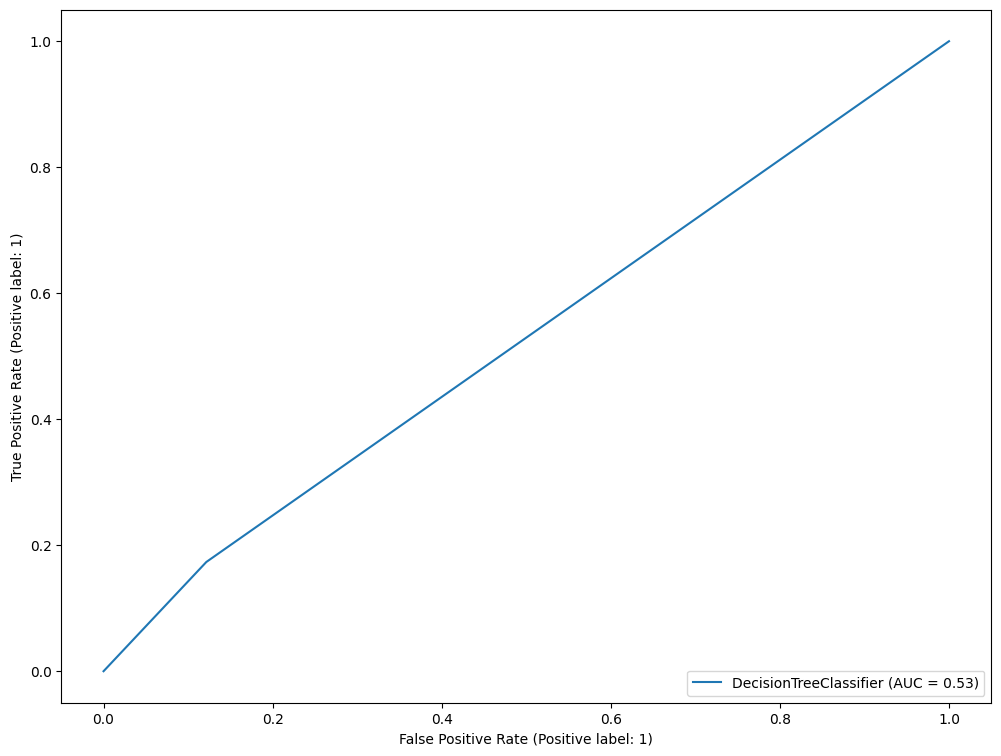

In [44]:
dt = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt.fit(X_train, y_train)

RocCurveDisplay.from_estimator(dt, X_val, y_val)

The decision tree outperforms the logistic regression model by 0.02, and its AUC is above 0.5!

Random Forest

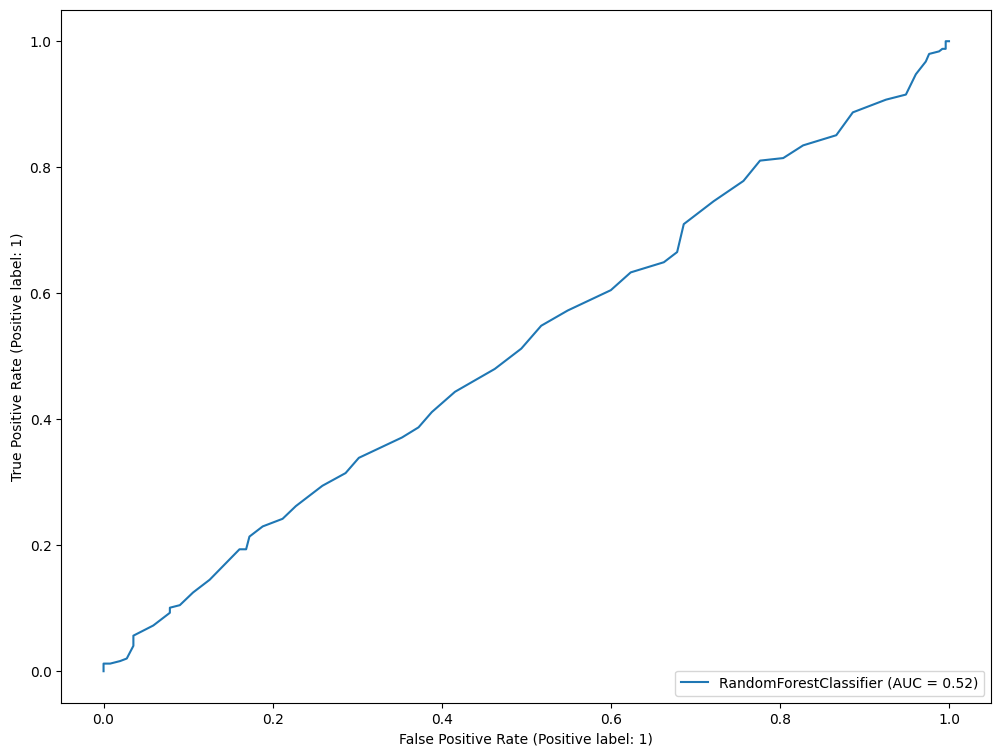

In [46]:
rf = RandomForestClassifier(random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

RocCurveDisplay.from_estimator(rf, X_val, y_val)

Contrary to our expectation, the model does not outperform the decision tree, it actually performs the same.

Gradient Boosting Ensemble

One last ensemble technique that we would like to try is gradient boosting. This algorithm sets up the stage for our next part, where we will try a deep learning approach to solve the problem.

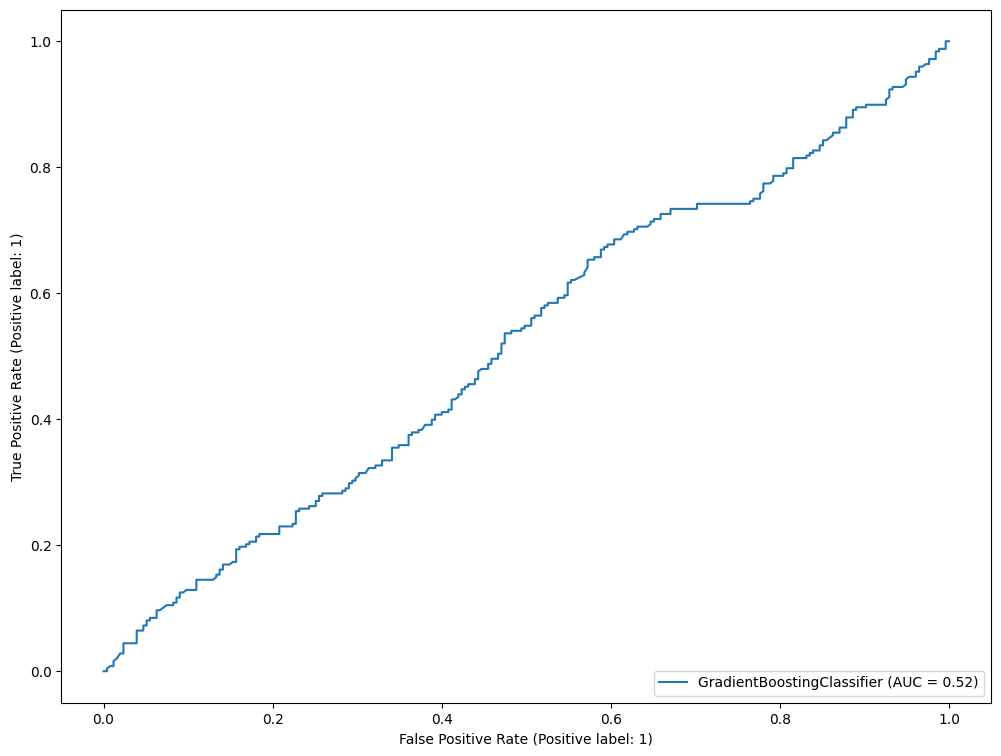

In [49]:
gb = GradientBoostingClassifier(random_state=RANDOM_SEED)
gb.fit(X_train, y_train)

RocCurveDisplay.from_estimator(gb, X_val, y_val)

the gradient boosting classifier outperform previous models and scored 0.55 AUC!

We find out that gradient boosting works best for this data set. In the next section, we will train a deep learning model with the aim to outperform the baseline set here, i.e., AUC = 0.55.

Deep Learning
Using Tensorflow to implement a small neural network.

In [53]:
# set seed for reproducibility of results
tf.random.set_seed(RANDOM_SEED)

print("Tensorflow version", tf.__version__)

Tensorflow version 2.13.0


In [54]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Normalization(axis=-1),
    tf.keras.layers.Dense(10, input_shape=[X_train.shape[1],], activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'),
    tf.keras.layers.Dropout(0.2, seed=RANDOM_SEED),
    tf.keras.layers.Dense(5, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'),
    tf.keras.layers.Dense(1, activation="sigmoid", kernel_initializer='random_normal', bias_initializer='zeros')
])

In [55]:
# this configures the model's loss function, weight optimizer, and metrics to keep track of
model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['AUC']
)

We are going to train our model for 50 epochs, and keep track of its loss (binary_crossentropy) and AUC values during each epoch.

To prevent overfitting, we are implementing two callbacks: (1) learning rate scheduler, and (2) early stopping callback.

In [56]:
def learning_rate_scheduler(epoch, learning_rate):
    """Learning rate decay callback."""
    if epoch < 5:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.01)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)

In [57]:
# the model.fit(...) method returns a 'history' object with stats about the training
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    verbose=1,
    callbacks=[early_stopping_callback, learning_rate_callback])

Epoch 1/50
150/150 [==============================] - 2s 3ms/step - loss: 151.7227 - auc: 0.5001 - val_loss: 0.6931 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/50
150/150 [==============================] - 0s 2ms/step - loss: 0.9410 - auc: 0.4942 - val_loss: 0.6931 - val_auc: 0.5000 - lr: 0.0010
Epoch 3/50
150/150 [==============================] - 0s 2ms/step - loss: 1.1345 - auc: 0.4960 - val_loss: 0.6931 - val_auc: 0.5000 - lr: 0.0010
Epoch 4/50
150/150 [==============================] - 0s 2ms/step - loss: 1.0035 - auc: 0.5030 - val_loss: 0.6931 - val_auc: 0.5000 - lr: 0.0010
Epoch 5/50
150/150 [==============================] - 0s 2ms/step - loss: 0.9924 - auc: 0.4874 - val_loss: 0.6931 - val_auc: 0.5000 - lr: 0.0010
Epoch 6/50
150/150 [==============================] - 0s 3ms/step - loss: 0.9822 - auc: 0.4964 - val_loss: 0.6931 - val_auc: 0.5000 - lr: 9.9005e-04
Epoch 7/50
150/150 [==============================] - 0s 2ms/step - loss: 1.0274 - auc: 0.5045 - val_loss: 0.6931 - val_auc:

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense (Dense)               (None, 10)                100       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 180 (724.00 Byte)
Trainable params: 161 (644.00 Byte)
Non-trainable params: 19 (80.00 Byte)
________________

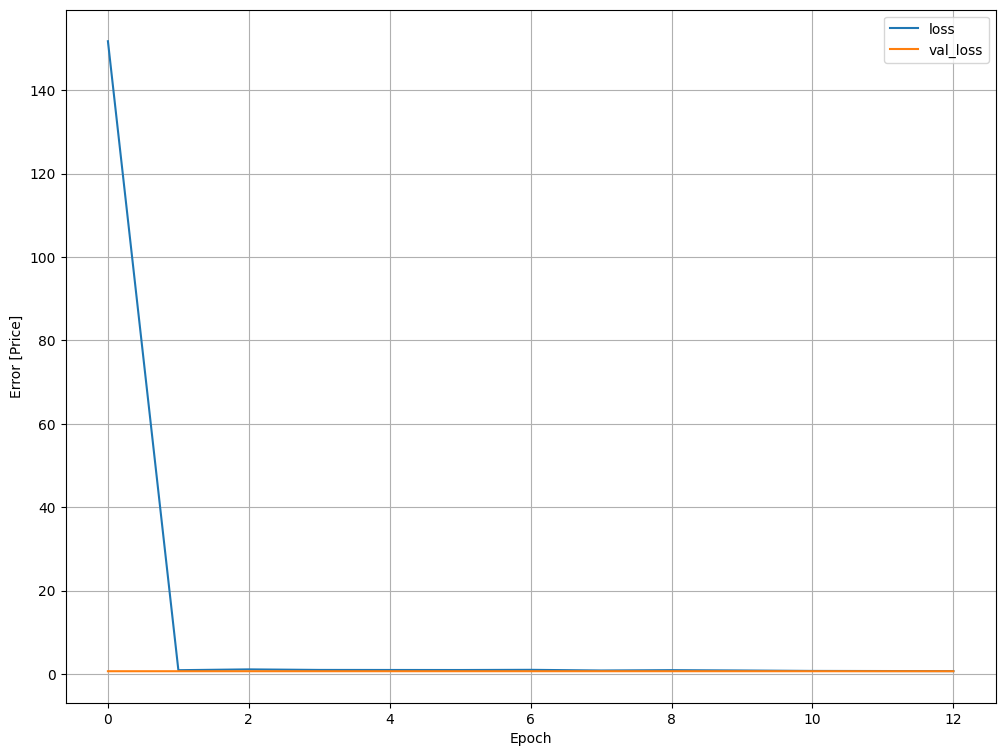

In [59]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [Price]')
plt.legend()
plt.grid(True)

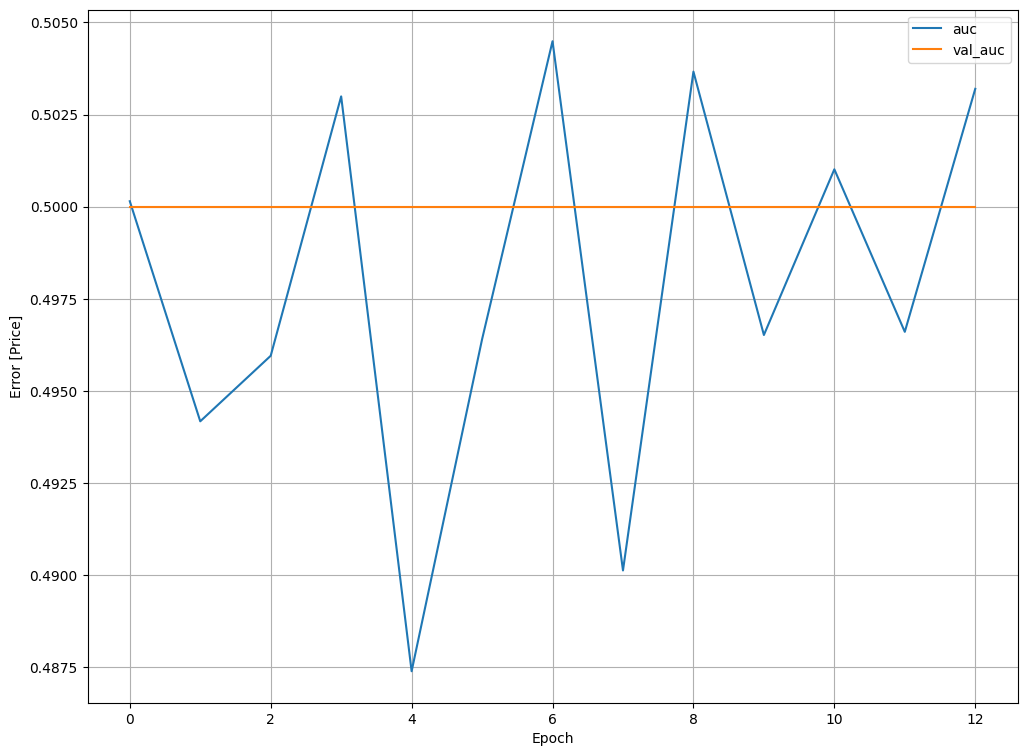

In [60]:
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('Error [Price]')
plt.legend()
plt.grid(True)


Conclusions
The gradient boosting classifier provided the best AUC score on the validation set.
It is a common machine learning practice to train multiple models on the same train/validation data set and provide a model that works best.
To simulate a production environment, we have held the test set aside until now.

In the next cell, we are going to evaluate the performance of the gradient boosting classifier on the test set. 
This is simple as calling plot_roc_curve with the test set instead of the validation one.

In the last cell, I will look at the feature importance plot, which plots the importance of each feature in regard to the predictive performance of the model (the higher the value the more important the feature is for determining the value of the target variable).

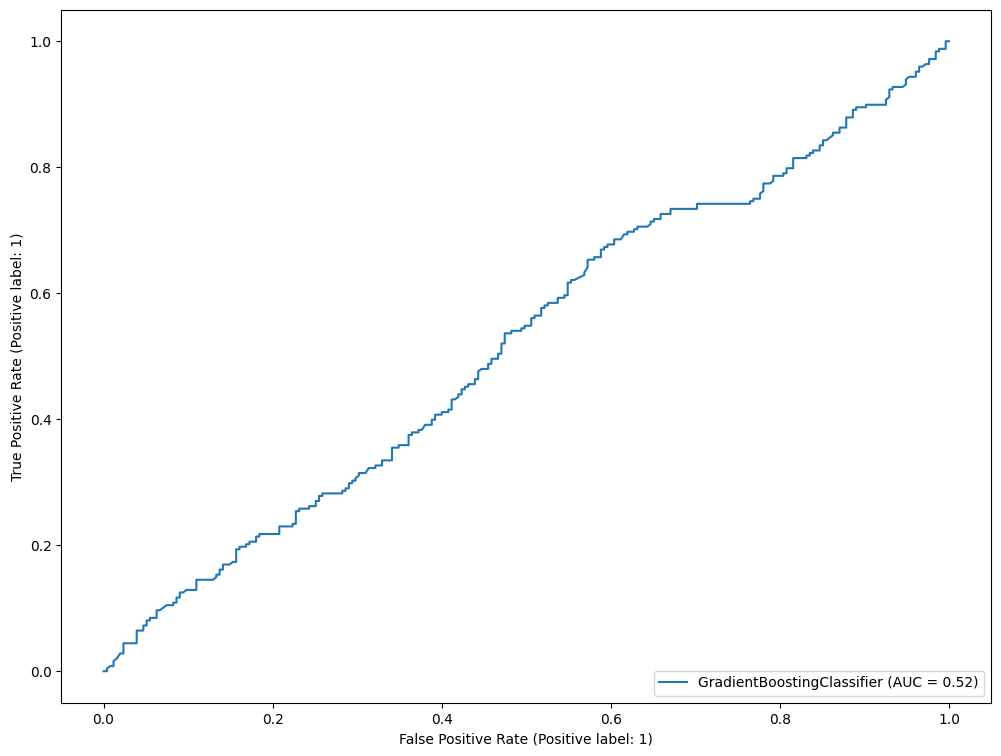

In [61]:
RocCurveDisplay.from_estimator(gb, X_test, y_test)

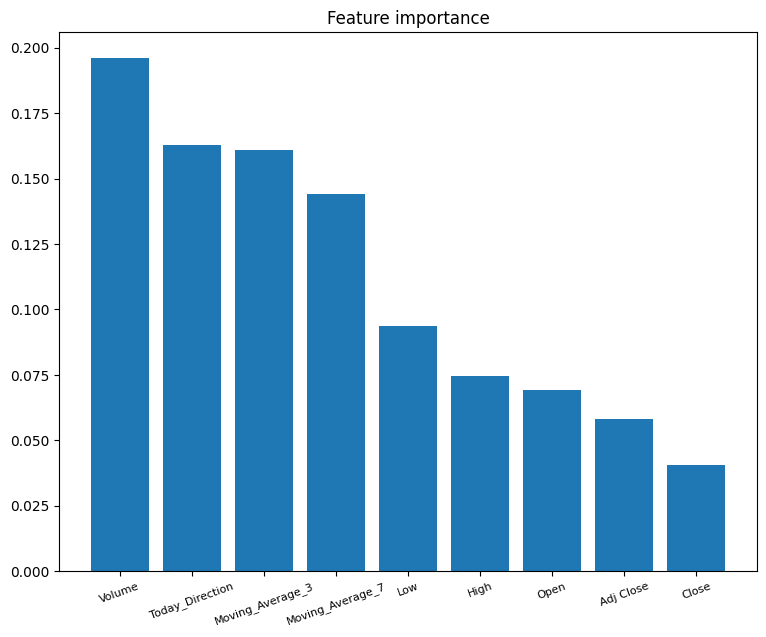

In [63]:
# Calculating feature importances
importances = gb.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [df_train[X_cols].columns[i] for i in indices]

_ = plt.figure(figsize=(9, 7))
plt.bar(names, importances[indices])
_ = plt.title("Feature importance")
_ = plt.xticks(rotation=20, fontsize = 8)